
# GEFCom2012 – Linear Regression Baseline for Wind Power (Station 3)

This notebook implements a **linear regression pipeline** to predict the normalized power output of station **3** (`wp3`)
from meteorological forecasts, following four main steps:

1. **Sanity checks & temporal alignment** between ECMWF forecasts and power measurements.  
2. **Exploratory data analysis (EDA)** – understanding the relationship between wind and power.  
3. **Feature engineering** – building a feature matrix that makes the relationship “as linear as possible”.  
4. **Linear model training & evaluation**, compared to a simple **persistence baseline**.

The code expects the original GEFCom2012 wind track files to be available as:

- `Wind/train.csv` – hourly normalized power outputs `wp1`–`wp7`  
- `Wind/windforecasts_wf3.csv` – ECMWF forecasts for wind farm 3


In [58]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

plt.rcParams["figure.figsize"] = (8, 4)


## 1. Load and align data

In [59]:

DATA_DIR = Path("Wind")  # adapt this if your folder is different

train_path = DATA_DIR / "train.csv"
forecast_path = DATA_DIR / "windforecasts_wf3.csv"

print(train_path.resolve())
print(forecast_path.resolve())

# --- Load power data ---
df_power = pd.read_csv(train_path, delim_whitespace=True)
df_power["date"] = pd.to_datetime(df_power["date"], format="%Y%m%d%H")
df_power = df_power.set_index("date").sort_index()

# We focus on station 3
df_power = df_power[["wp3"]]

df_power.head()


C:\Users\henri\Desktop\PSC\Data-study\ForecastingData\Wind\train.csv
C:\Users\henri\Desktop\PSC\Data-study\ForecastingData\Wind\windforecasts_wf3.csv


C:\Users\henri\AppData\Local\Temp\ipykernel_21700\835089849.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_power = pd.read_csv(train_path, delim_whitespace=True)


,wp3
date,
2009-07-01 00:00:00,0.494
2009-07-01 01:00:00,0.257
2009-07-01 02:00:00,0.178
2009-07-01 03:00:00,0.109
2009-07-01 04:00:00,0.079


In [60]:

# --- Load meteorological forecasts for wind farm 3 ---
df_fc = pd.read_csv(forecast_path)
df_fc["date"] = pd.to_datetime(df_fc["date"], format="%Y%m%d%H")

# Keep only short-term forecasts (1–12h ahead)
df_fc = df_fc[df_fc["hors"].between(1, 12)]

# Convert 'hors' (forecast horizon) into a timedelta and shift to valid time
df_fc["valid_time"] = df_fc["date"] + pd.to_timedelta(df_fc["hors"], unit="h")

# For each valid_time, we may have multiple horizons; here we simply keep the *shortest* horizon
# (you can experiment with other aggregation strategies).
df_fc = df_fc.sort_values(["valid_time", "hors"])
df_fc_shortest = df_fc.groupby("valid_time").first().reset_index()

# Set index to valid_time to align with power
df_fc_shortest = df_fc_shortest.set_index("valid_time").sort_index()

df_fc_shortest.head()


,date,hors,u,v,ws,wd
valid_time,,,,,,
2009-07-01 01:00:00,2009-07-01,1,3.51,-2.43,4.27,124.75
2009-07-01 02:00:00,2009-07-01,2,2.96,-2.12,3.65,125.63
2009-07-01 03:00:00,2009-07-01,3,2.47,-2.02,3.19,129.29
2009-07-01 04:00:00,2009-07-01,4,2.05,-2.06,2.90,135.14
2009-07-01 05:00:00,2009-07-01,5,1.72,-2.11,2.72,140.85


In [61]:

# --- Align forecasts with realized power ---
# After this join, each row corresponds to one "valid_time"
df = df_fc_shortest.join(df_power, how="inner")

print("Aligned shape:", df.shape)
print(df[["hors", "u", "v", "ws", "wd", "wp3"]].head())

# Drop any remaining missing values (if any)
df = df.dropna(subset=["wp3", "u", "v", "ws"])

print("After dropping NAs:", df.shape)


Aligned shape: (13175, 7)
                     hors     u     v    ws      wd    wp3
2009-07-01 01:00:00     1  3.51 -2.43  4.27  124.75  0.257
2009-07-01 02:00:00     2  2.96 -2.12  3.65  125.63  0.178
2009-07-01 03:00:00     3  2.47 -2.02  3.19  129.29  0.109
2009-07-01 04:00:00     4  2.05 -2.06  2.90  135.14  0.079
2009-07-01 05:00:00     5  1.72 -2.11  2.72  140.85  0.099
After dropping NAs: (13175, 7)


## 2. Exploratory data analysis

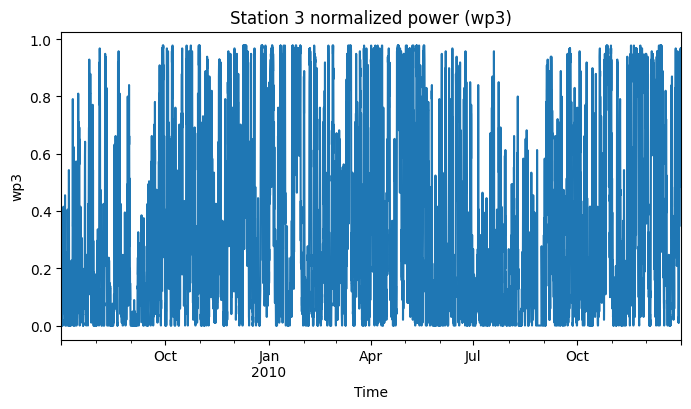

In [62]:

# Time series of wp3
df["wp3"].plot(title="Station 3 normalized power (wp3)")
plt.xlabel("Time")
plt.ylabel("wp3")
plt.show()


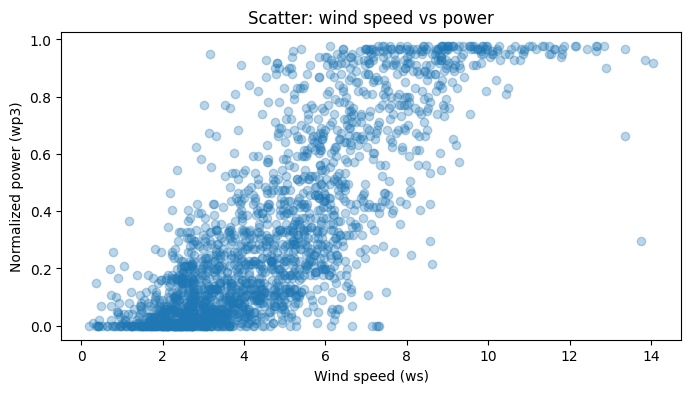

In [63]:

# Scatter: wind speed vs power
sample = df.sample(min(len(df), 2000), random_state=0)  # subsample for readability

plt.scatter(sample["ws"], sample["wp3"], alpha=0.3)
plt.xlabel("Wind speed (ws)")
plt.ylabel("Normalized power (wp3)")
plt.title("Scatter: wind speed vs power")
plt.show()


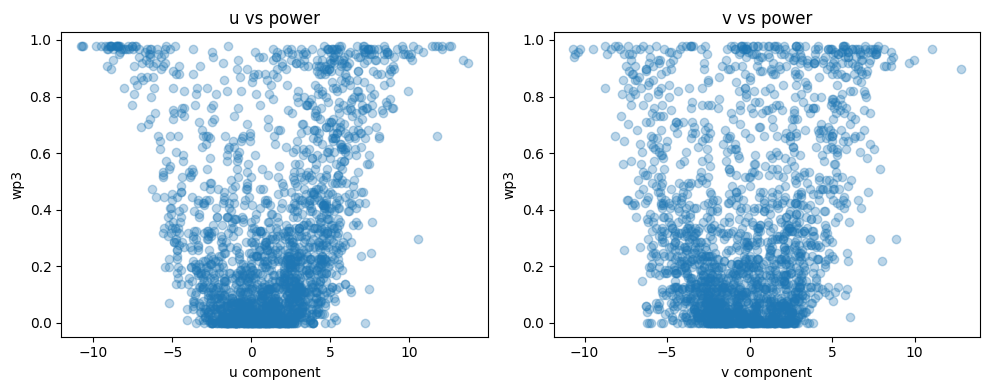

In [64]:

# Scatter: u and v vs power
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].scatter(sample["u"], sample["wp3"], alpha=0.3)
axes[0].set_xlabel("u component")
axes[0].set_ylabel("wp3")
axes[0].set_title("u vs power")

axes[1].scatter(sample["v"], sample["wp3"], alpha=0.3)
axes[1].set_xlabel("v component")
axes[1].set_ylabel("wp3")
axes[1].set_title("v vs power")

plt.tight_layout()
plt.show()


## 3. Feature engineering

In [65]:

def add_time_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    # Index is valid_time
    dt_index = df.index

    df["hour"] = dt_index.hour
    df["dayofyear"] = dt_index.dayofyear

    # Cyclic encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)

    df["doy_sin"] = np.sin(2 * np.pi * df["dayofyear"] / 365)
    df["doy_cos"] = np.cos(2 * np.pi * df["dayofyear"] / 365)

    return df

df_feat = add_time_features(df)

df_feat[["u", "v", "ws", "hors", "hour", "dayofyear", "wp3"]].head()


,u,v,ws,hors,hour,dayofyear,wp3
2009-07-01 01:00:00,3.51,-2.43,4.27,1,1,182,0.257
2009-07-01 02:00:00,2.96,-2.12,3.65,2,2,182,0.178
2009-07-01 03:00:00,2.47,-2.02,3.19,3,3,182,0.109
2009-07-01 04:00:00,2.05,-2.06,2.90,4,4,182,0.079
2009-07-01 05:00:00,1.72,-2.11,2.72,5,5,182,0.099


In [66]:

# Define feature columns and target
base_features = ["u", "v", "ws", "hors", "hour_sin", "hour_cos", "doy_sin", "doy_cos"]
target_col = "wp3"

X_all = df_feat[base_features].copy()
y_all = df_feat[target_col].values

print("Feature matrix shape:", X_all.shape)


Feature matrix shape: (13175, 8)


### Train/validation split (by time)

In [67]:

# Simple chronological train/validation split: first 80% train, last 20% validation
n = len(df_feat)
split_idx = int(0.8 * n)

X_train = X_all.iloc[:split_idx]
y_train = y_all[:split_idx]

X_valid = X_all.iloc[split_idx:]
y_valid = y_all[split_idx:]

print("Train size:", X_train.shape, "Validation size:", X_valid.shape)


Train size: (10540, 8) Validation size: (2635, 8)


### Persistence baseline

In [68]:

# Persistence: predict wp3(t) = wp3(t-1)
y_all_series = df_feat[target_col]

# Shift by one hour to create prediction
y_persist = y_all_series.shift(1)

# Align with validation period
y_persist_valid = y_persist.iloc[split_idx:]
y_valid_aligned = y_all_series.iloc[split_idx:]

mask = ~y_persist_valid.isna()
y_persist_valid = y_persist_valid[mask]
y_valid_aligned = y_valid_aligned[mask]

rmse_persist = root_mean_squared_error(y_valid_aligned, y_persist_valid)
print(f"Persistence RMSE on validation: {rmse_persist:.4f}")


Persistence RMSE on validation: 0.1017


## 4. Linear regression models

### 4.1 Simple linear regression (no polynomial features)

In [69]:

lin_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

lin_pipeline.fit(X_train, y_train)

y_pred_lin = lin_pipeline.predict(X_valid)
rmse_lin = root_mean_squared_error(y_valid, y_pred_lin)
r2_lin = r2_score(y_valid, y_pred_lin)

print(f"LinearRegression – RMSE: {rmse_lin:.4f}, R²: {r2_lin:.4f}")


LinearRegression – RMSE: 0.1705, R²: 0.7333


### 4.2 Polynomial + Ridge regression

In [70]:

poly_ridge_pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0]))
])

poly_ridge_pipeline.fit(X_train, y_train)

y_pred_poly = poly_ridge_pipeline.predict(X_valid)
rmse_poly = root_mean_squared_error(y_valid, y_pred_poly)
r2_poly = r2_score(y_valid, y_pred_poly)

print(f"Poly (deg=3) + Ridge – RMSE: {rmse_poly:.4f}, R²: {r2_poly:.4f}")
print("Selected alpha:", poly_ridge_pipeline.named_steps["ridge"].alpha_)


Poly (deg=3) + Ridge – RMSE: 0.1560, R²: 0.7766
Selected alpha: 1.0


### 4.3 Diagnostics – predicted vs. actual

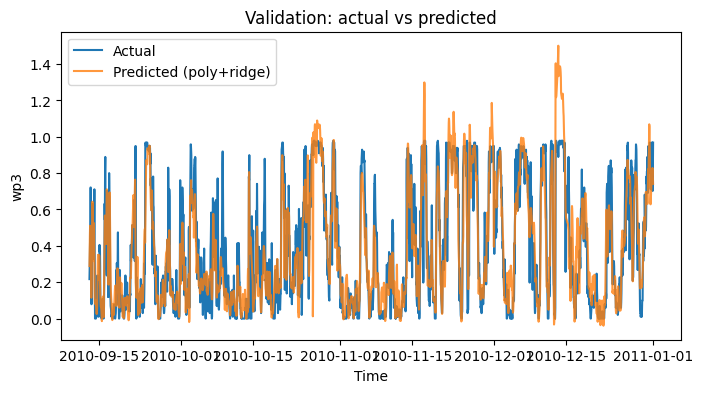

In [71]:

# Time series comparison on the validation window
plt.plot(df_feat.index[split_idx:], y_valid, label="Actual")
plt.plot(df_feat.index[split_idx:], y_pred_poly, label="Predicted (poly+ridge)", alpha=0.8)
plt.xlabel("Time")
plt.ylabel("wp3")
plt.title("Validation: actual vs predicted")
plt.legend()
plt.show()


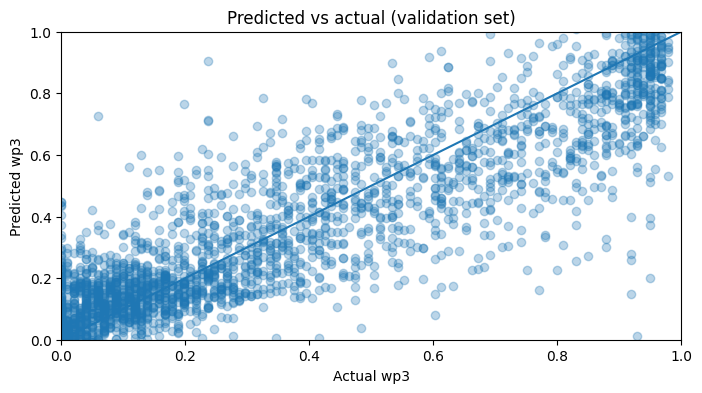

In [72]:

# Scatter plot: predicted vs actual
plt.scatter(y_valid, y_pred_poly, alpha=0.3)
lims = [0, 1]
plt.plot(lims, lims)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Actual wp3")
plt.ylabel("Predicted wp3")
plt.title("Predicted vs actual (validation set)")
plt.show()
